In [1]:
import frontmatter
from collections import defaultdict
from pathlib import Path
import git
from datetime import date
import matplotlib.pyplot as plt
import scienceplots

plt.style.use("science")
plt.style.use("notebook")
# plt.style.use('fivethirtyeight')

In [2]:
educator_keys = [
    "mentor",
    "instructor",
    "author",
    "facilitator",
    "material",  # deprecated for author
]

educator_key_mapping = {"material": "author"}

In [3]:
repo = git.Repo("~/Documents/23/git_sync/hsf.github.io/")

In [4]:
path = "_profiles"

educator_counts = defaultdict(list)
times = []

for commit in repo.iter_commits(paths=path):
    try:
        traversable = (commit.tree / "_profiles").traverse()
    except (KeyError, IndexError, ValueError):
        continue
    try:
        educator_count = defaultdict(int)
        for entry in traversable:
            content = repo.git.show("{}:{}".format(commit.hexsha, entry.path))
            try:
                dct = frontmatter.loads(content)
            except Exception as e:  # ParserError, where are you defined? ;)
                print(e)
                continue
            keys = dct.get("training_roles", [])
            if keys is None:
                continue
            roles = [r.casefold() for r in keys]
            for k in educator_keys:
                if k in roles:
                    educator_count[educator_key_mapping.get(k, k)] += 1
                else:
                    # ensure key is present
                    educator_count[educator_key_mapping.get(k, k)] += 0
            if roles:
                educator_count["all"] += 1
        print(commit, educator_count)
        for k, v in educator_count.items():
            educator_counts[k].append(v)
        times.append(commit.authored_date)
    except IndexError:
        continue

6153f702119296068c7a210e9aafba3f2e8d55c9 defaultdict(<class 'int'>, {'mentor': 50, 'instructor': 39, 'author': 19, 'facilitator': 15, 'all': 67})
26047c73278cf35fa7cb6341c4220d164da8d681 defaultdict(<class 'int'>, {'mentor': 50, 'instructor': 39, 'author': 19, 'facilitator': 15, 'all': 67})
5046c0446654087482210acc007763ee6922fa64 defaultdict(<class 'int'>, {'mentor': 49, 'instructor': 39, 'author': 19, 'facilitator': 15, 'all': 66})
8bd9b43dc6334d644536850638d548e1e06e6576 defaultdict(<class 'int'>, {'mentor': 49, 'instructor': 39, 'author': 19, 'facilitator': 15, 'all': 66})
5b83a7bbf63a44f0ac1c07db4f15d0aa51b0f2b0 defaultdict(<class 'int'>, {'mentor': 49, 'instructor': 38, 'author': 19, 'facilitator': 15, 'all': 65})
6ccfe826c549974782ce120db7df8a6f1aeabd2f defaultdict(<class 'int'>, {'mentor': 49, 'instructor': 37, 'author': 19, 'facilitator': 15, 'all': 64})
e9ef529ae5109e54dc1941bce9937f363db4431e defaultdict(<class 'int'>, {'mentor': 49, 'instructor': 37, 'author': 19, 'facilita

In [6]:
dt_times = [date.fromtimestamp(t) for t in times]

/tmp/ipykernel_160232/343530767.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks,rotation=50)


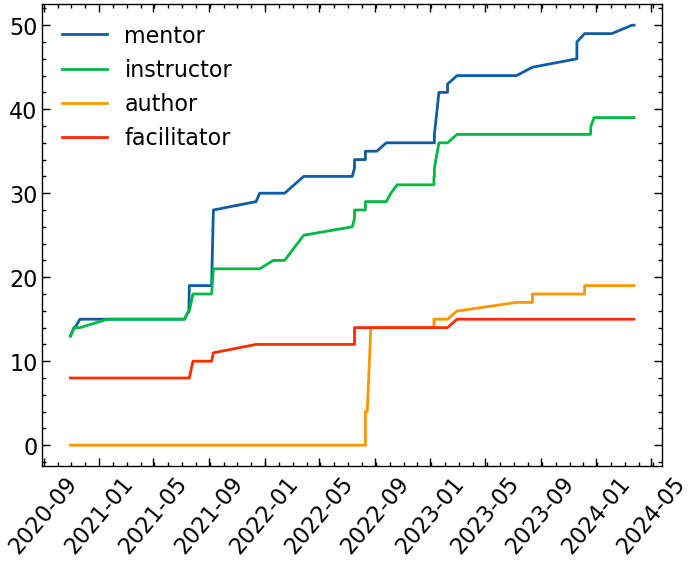

In [7]:
_, ax = plt.subplots()

for k, vs in educator_counts.items():
    if k == "all":
        continue
    # print(k, vs)
    ax.plot(dt_times, vs, label=k)
ax.legend(frameon=False)
xticks = ax.get_xticklabels()
ax.set_xticklabels(xticks,rotation=50)
plt.show()

In [8]:
import pandas as pd

data_dir = Path(".").resolve().parent / "data"
assert data_dir.is_dir()

pd.Series(educator_counts["all"], index=dt_times).to_csv(
    data_dir / "total_educators.csv"
)